In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import matplotlib

# 1 简单模型回归

In [2]:
# 读取四个CSV文件，并添加位置标识
RENT = 1
NOT_RENT = 0

def read_files(files, locations):
    dataframes = []
    for f, loc in zip(files, locations):
        df = pd.read_csv(f)
        df["location"] = loc  # 添加位置标识
        dataframes.append(df)
        
    # 合并成一个总的DataFrame
    data = pd.concat(dataframes, ignore_index=True)
    
    return data

In [3]:
# 机器学习来训练模型
def training(data, is_rent):
    # 数值型特征
    X_numeric = data[["area_clean"]]

    # 对location做one-hot编码
    X_location = pd.get_dummies(data["location"], drop_first=True)

    # 合并特征
    X = pd.concat([X_numeric, X_location], axis=1)
    y = data["unit_price_clean"]

    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 建立回归模型
    model = LinearRegression()
    model.fit(X_train, y_train)

    # 模型评估
    y_pred = model.predict(X_test)
    print("R2:", r2_score(y_test, y_pred))
    
    # 绘制图像
    # 设置字体为支持中文的字体
    matplotlib.rcParams['font.family'] = 'SimHei'  # 黑体
    matplotlib.rcParams['axes.unicode_minus'] = False

    for loc in data['location'].unique():
        # 选出当前location的数据
        df_loc = data[data['location'] == loc]
        
        # 横轴：面积
        area_values = np.linspace(df_loc['area_clean'].min(), df_loc['area_clean'].max(), 100)
        
        # 构建预测样本，location列要做虚拟变量处理
        sample = pd.DataFrame({'area_clean': area_values, 'location': [loc]*len(area_values)})
        sample_encoded = pd.get_dummies(sample['location'], drop_first=True)
        
        # 补齐训练数据中所有虚拟变量列
        for col in X.columns:
            if col not in sample_encoded.columns and col != 'area_clean':
                sample_encoded[col] = 0
        sample_encoded = pd.concat([sample[['area_clean']], sample_encoded], axis=1)
        sample_encoded = sample_encoded[X.columns]  # 保持列顺序
        
        # 预测
        y_pred_curve = model.predict(sample_encoded)
        
        # 绘图
        plt.figure(figsize=(6,4))
        plt.scatter(df_loc['area_clean'], df_loc['unit_price_clean'], color='blue', alpha=0.2, label='真实价格')
        plt.plot(area_values, y_pred_curve, color='red', label='预测价格', linewidth=2)
        plt.xlabel("面积")
        plt.ylabel("价格")
        plt.title(f"{loc} 每平方米 {'租赁' if is_rent else '售卖'} 价格")
        plt.legend()
        plt.show()
    
    return X, model

In [4]:
# 数据预测和保存
def predict_and_save(data, data_copy, model, X, is_rent):
    # 数值特征
    X_numeric = data[["area_clean"]]

    # location虚拟变量
    X_location = pd.get_dummies(data["location"], drop_first=True)

    # 合并特征
    X_all = pd.concat([X_numeric, X_location], axis=1)

    # 确保列顺序和训练时一致
    X_all = X_all[X.columns]

    # 用回归模型进行预测
    data_copy["predicted_unit_price"] = model.predict(X_all).round(2)
    data_copy["area_clean"] = data["area_clean"].round(2)
    data_copy['unit_price_clean'] = data["unit_price_clean"].round(2)


    # 保存为新的 CSV 文件
    data_copy.to_csv(f"./predicted_data/{'rent' if is_rent else 'price'}_data_with_predictions.csv", index=False)
    print("预测已添加到原始数据，并保存。")


In [5]:
# 图像绘制
def draw_figure(median_dict, tag):
    for key, item in median_dict.items():
        print(f'{key} 中位数: {round(item, 2)}')
    # 提取名称和数值
    names = list(median_dict.keys())
    values = list(median_dict.values())

    # 设置字体为支持中文的字体
    matplotlib.rcParams['font.family'] = 'SimHei'  # 黑体
    matplotlib.rcParams['axes.unicode_minus'] = False

    # 绘制条形图
    plt.figure(figsize=(8, 5))
    plt.bar(names, values, color='lightblue')

    # 添加标题和标签
    plt.title('The Median Price to Rent Ratio')
    plt.xlabel('location')
    plt.ylabel('Rent Ratio')

    # 显示图表
    plt.savefig('./figures/' + tag + '.png', dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

## 1.1 售卖数据回归结果

R2: 0.16623738890687345


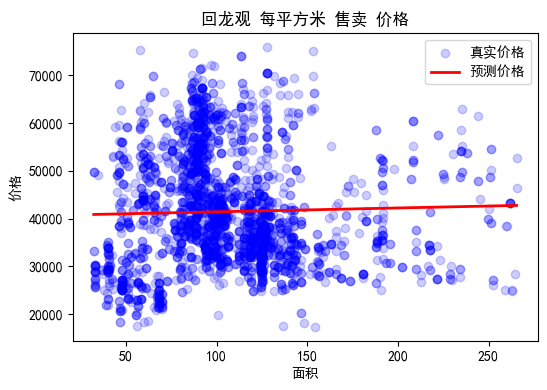

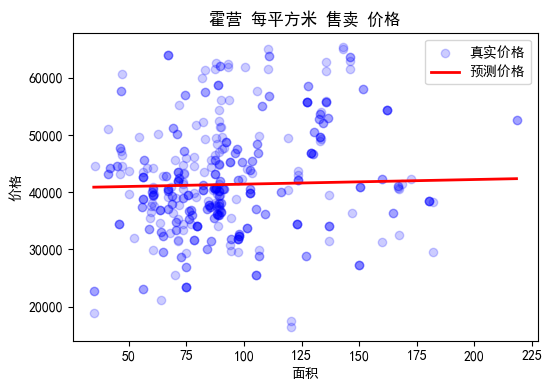

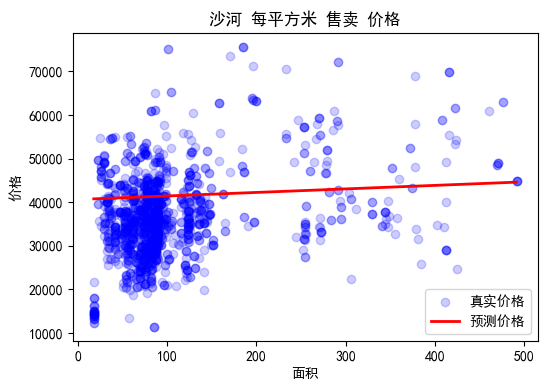

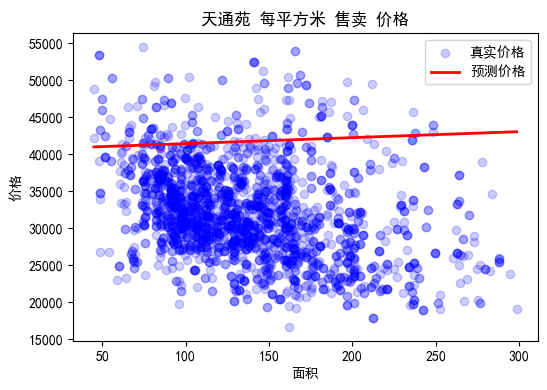

预测已添加到原始数据，并保存。


In [6]:
# 售卖数据模型
files = ["./cleaned_data/cleaned_price_回龙观.csv", "./cleaned_data/cleaned_price_霍营.csv", 
         "./cleaned_data/cleaned_price_沙河.csv", "./cleaned_data/cleaned_price_天通苑.csv"]
locations = ["回龙观", "霍营", "沙河", "天通苑"]

price_data = read_files(files, locations)
price_data_copy = price_data.copy()
X, model = training(price_data, NOT_RENT)
predict_and_save(price_data, price_data_copy, model, X, NOT_RENT)

## 1.2 租赁数据回归模型结果

R2: 0.4316830366622325


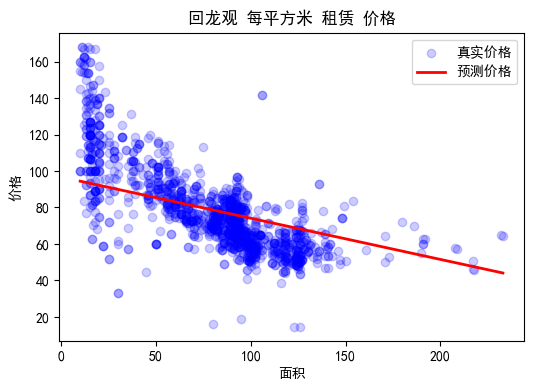

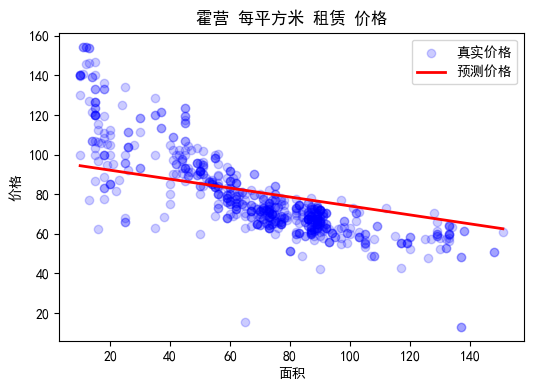

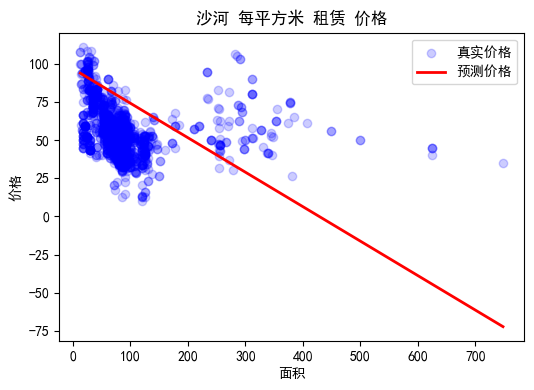

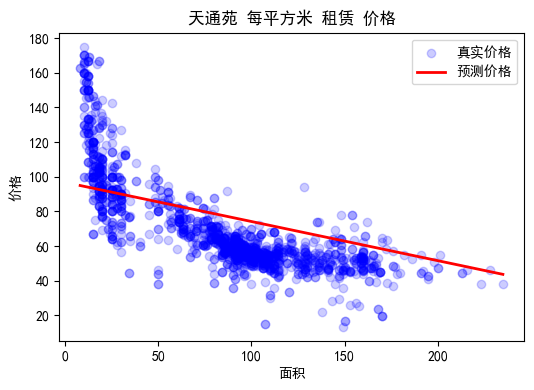

预测已添加到原始数据，并保存。


In [7]:
# 租赁数据模型
files = ["./cleaned_data/cleaned_rent_回龙观.csv", "./cleaned_data/cleaned_rent_霍营.csv", 
         "./cleaned_data/cleaned_rent_沙河.csv", "./cleaned_data/cleaned_rent_天通苑.csv"]
locations = ["回龙观", "霍营", "沙河", "天通苑"]

rent_data = read_files(files, locations)
rent_data_copy = rent_data.copy()
X, model = training(rent_data, RENT)
predict_and_save(rent_data, rent_data_copy, model, X, RENT)

## 1.3 Figure B 绘制

回龙观 中位数: 555.14
天通苑 中位数: 468.48
沙河 中位数: 580.24
霍营 中位数: 753.61


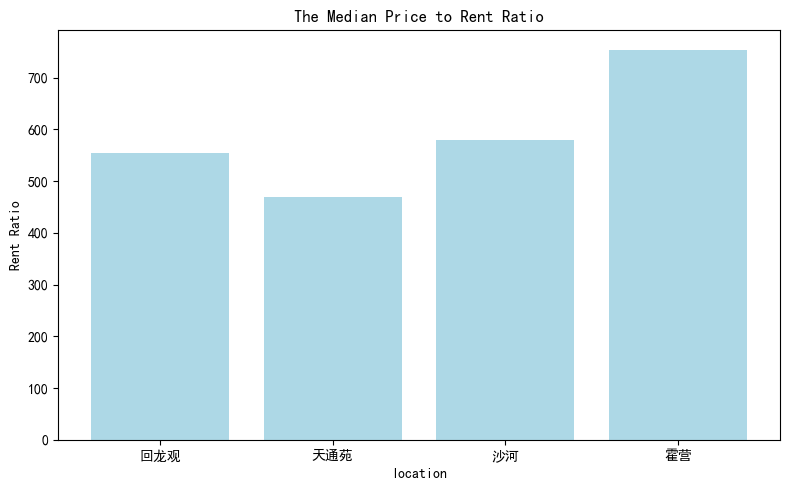

In [8]:
# Figure B绘制

price_data_copy['rent_ratio'] = price_data_copy['predicted_unit_price'] / rent_data_copy['predicted_unit_price']
# 根据 location 分组计算 predicted_unit_price 的中位数
median_series = price_data_copy.groupby("location")['rent_ratio'].median()

# 转换为字典
median_dict = median_series.to_dict()

draw_figure(median_dict, 'figure_B')

# 2 PRO MAX模型回归

In [9]:
# 机器学习来训练模型
def promax_training(data, is_rent):
    # 非线性特征
    X_nonlinear = data[["area_clean"]] * data[["area_clean"]]
    
    # 数值型特征
    X_numeric = data[["area_clean"]]

    # 对location做one-hot编码
    X_location = pd.get_dummies(data["location"], drop_first=True)
    
    # 交互项
    X_interaction = X_location.multiply(data["area_clean"], axis=0)
    
    # 合并特征
    X = pd.concat([X_numeric, X_nonlinear, X_location, X_interaction], axis=1)
    y = data["unit_price_clean"]
    
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 建立回归模型
    model = LinearRegression()
    model.fit(X_train, y_train)

    # 模型评估
    y_pred = model.predict(X_test)
    print("R2:", r2_score(y_test, y_pred))
    
    # 绘制图像
    # 设置字体为支持中文的字体
    matplotlib.rcParams['font.family'] = 'SimHei'  # 黑体
    matplotlib.rcParams['axes.unicode_minus'] = False

    for loc in data['location'].unique():
        # 选出当前location的数据
        df_loc = data[data['location'] == loc]
        
        # 横轴：面积
        area_values = np.linspace(df_loc['area_clean'].min(), df_loc['area_clean'].max(), 100)
        
        # 构建预测样本，location列要做虚拟变量处理
        sample = pd.DataFrame({'area_clean': area_values, 'location': [loc]*len(area_values)})
        sample_encoded = pd.get_dummies(sample['location'], drop_first=True)
        
        # 补齐训练数据中所有虚拟变量列
        for col in X.columns:
            if col not in sample_encoded.columns and col != 'area_clean':
                sample_encoded[col] = 0
        sample_encoded = pd.concat([sample[['area_clean']], sample_encoded], axis=1)
        sample_encoded = sample_encoded[X.columns]  # 保持列顺序
        
        # 预测
        y_pred_curve = model.predict(sample_encoded)
        
        # 绘图
        plt.figure(figsize=(6,4))
        plt.scatter(df_loc['area_clean'], df_loc['unit_price_clean'], color='blue', alpha=0.2, label='真实价格')
        plt.plot(area_values, y_pred_curve, color='red', label='预测价格', linewidth=2)
        plt.xlabel("面积")
        plt.ylabel("价格")
        plt.title(f"{loc} 每平方米 {'租赁' if is_rent else '售卖'} 价格")
        plt.legend()
        plt.show()
    
    return X, model

## 2.1 售卖数据PROMAX模型回归结果

R2: 0.20419451098604602


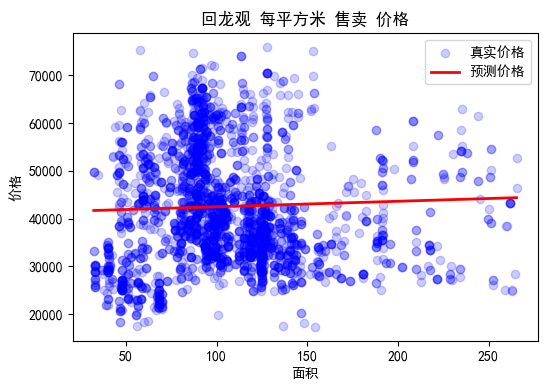

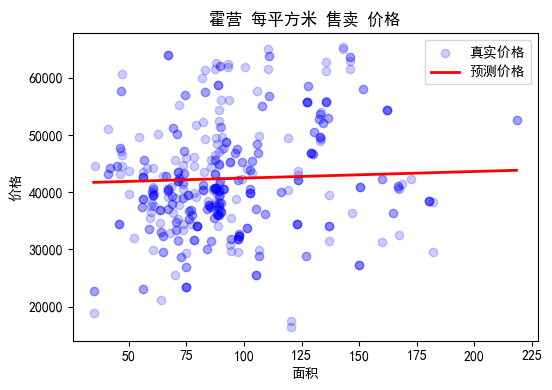

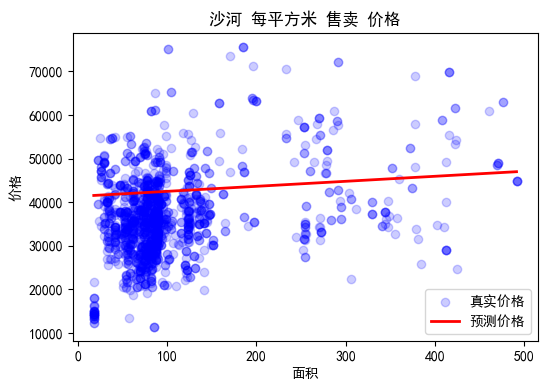

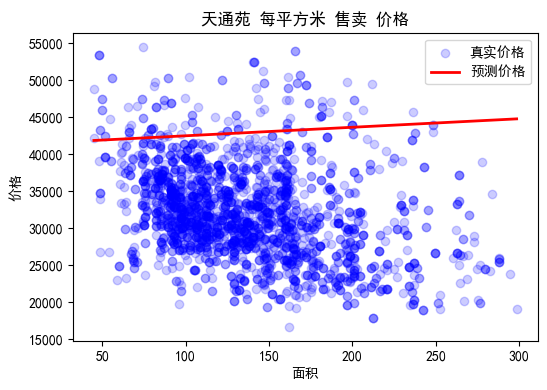

预测已添加到原始数据，并保存。


In [10]:
# 售卖数据模型
files = ["./cleaned_data/cleaned_price_回龙观.csv", "./cleaned_data/cleaned_price_霍营.csv", 
         "./cleaned_data/cleaned_price_沙河.csv", "./cleaned_data/cleaned_price_天通苑.csv"]
locations = ["回龙观", "霍营", "沙河", "天通苑"]

price_data = read_files(files, locations)
price_data_copy = price_data.copy()
X, model = promax_training(price_data, NOT_RENT)
predict_and_save(price_data, price_data_copy, model, X, NOT_RENT)

## 2.2 租赁数据PROMAX模型回归结果

R2: 0.6528324569373665


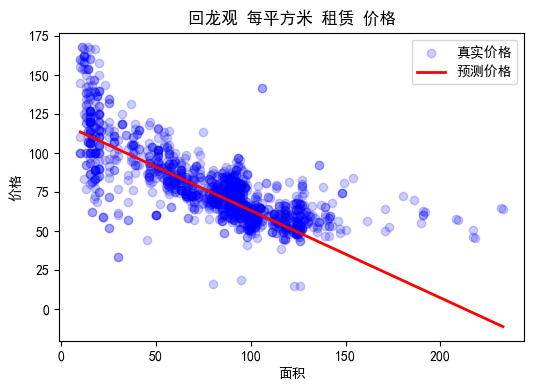

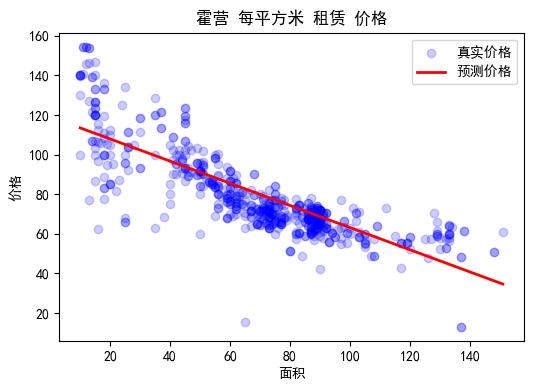

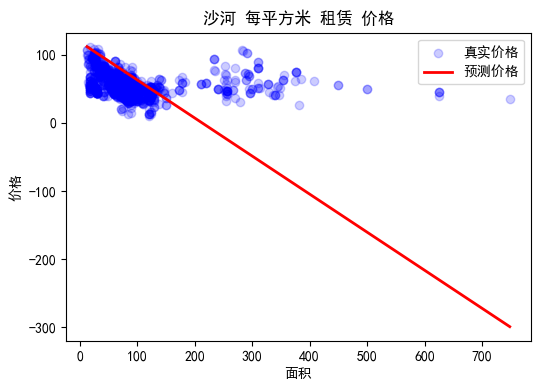

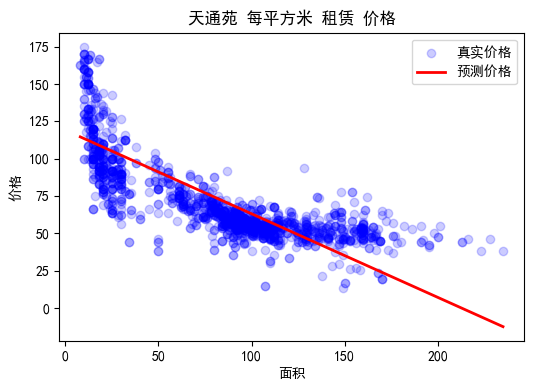

预测已添加到原始数据，并保存。


In [11]:
# 租赁数据模型
files = ["./cleaned_data/cleaned_rent_回龙观.csv", "./cleaned_data/cleaned_rent_霍营.csv", 
         "./cleaned_data/cleaned_rent_沙河.csv", "./cleaned_data/cleaned_rent_天通苑.csv"]
locations = ["回龙观", "霍营", "沙河", "天通苑"]

rent_data = read_files(files, locations)
rent_data_copy = rent_data.copy()
X, model = promax_training(rent_data, RENT)
predict_and_save(rent_data, rent_data_copy, model, X, RENT)

## 2.3 Figure C绘制

回龙观 中位数: 624.12
天通苑 中位数: 625.74
沙河 中位数: 622.57
霍营 中位数: 1222.94


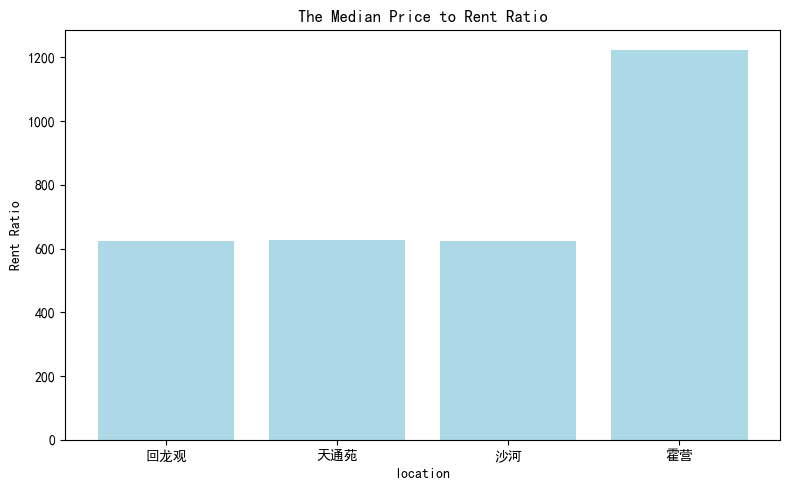

In [12]:
# Figure B绘制

price_data_copy['rent_ratio'] = price_data_copy['predicted_unit_price'] / rent_data_copy['predicted_unit_price']
# 根据 location 分组计算 predicted_unit_price 的中位数
median_series = price_data_copy.groupby("location")['rent_ratio'].median()

# 转换为字典
median_dict = median_series.to_dict()

draw_figure(median_dict, 'figure_C')